In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pandas as pd

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()


In [3]:
cell_meta = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial/GroupDesign/ITSpatial.cell_group_design.csv',
    index_col=0
)
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
).loc[cell_meta.index]
cell_tidy_data['ITSpatial'] = cell_meta['ITSpatial']


/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
mcds = xarray.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/GeneWithSlop2kb.gene_da_rate.*.mcds'
)
mcds = mcds.sel(mc_type='CHN', cell=cell_meta.index)
mcds = mcds.chunk({'cell': 50000})
mcds = mcds['gene_da']
mcds.astype(np.float32).to_netcdf('TEMP.nc')



/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  coords=coords)
/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 731 times more chunks
  return self.array[key]


In [4]:
mcds = xr.open_dataarray('TEMP.nc').load()
def get_gene(gene_name):
    return mcds.sel(gene=gene_name_to_id[gene_name]).to_pandas()

In [5]:
gene_meta = pd.read_csv('/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
                        sep='\t', index_col='gene_id')
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}

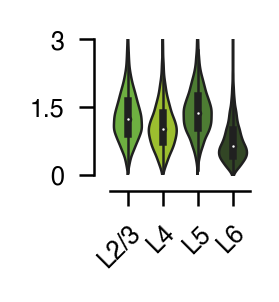

In [15]:
gene = 'Fosl2'

fig, ax = plt.subplots(figsize=(0.6, 0.6), dpi=300)
_data = cell_tidy_data[['MajorType']].copy()
_data['gene'] = get_gene(gene)
sns.violinplot(ax=ax, data=_data, x='MajorType', y='gene', scale='width', gridsize=300,
               palette=major_type_palette, 
               order=['IT-L23', 'IT-L4', 'IT-L5', 'IT-L6'])
ax.set_ylim(0, 3)
# ax.set_title(gene, fontsize=labelsize)
sns.despine(ax=ax, offset=4, bottom=False)

[t.set(rotation=45, rotation_mode='anchor', ha='right') for t in ax.xaxis.get_ticklabels()]
ax.set(xticklabels=['L2/3', 'L4', 'L5', 'L6'], ylabel='', xlabel='', yticks=[0, 1.5, 3], yticklabels=[0, 1.5, 3])

fig.savefig(f'{gene}.pdf', bbox_inches='tight')